# Document Filtering: Spam vs Ham  
### Feature Engineering → Naïve Bayes → Fisher’s Method

This notebook is designed to **follow the structure of the lecture slides** on document filtering (spam filtering as a case study):

1. **Problem definition**: classify a document (email/SMS) as *spam* or *ham*  
2. **Feature engineering**: Bag of Words and TF–IDF (as in the *Search & Ranking* lecture)  
3. **Approach A — Naïve Bayes**: estimate feature likelihoods \(p(f\mid c)\) and compute \(p(c\mid d)\)  
4. **Approach B — Fisher’s Method**: compute \(p(c\mid f)\) per feature and combine them via Fisher’s \(\chi^2\) test  
5. **Comparison + visualisation** and a short **summary**

> The code includes both **from-scratch** implementations (to expose the maths) and **scikit-learn baselines** (for reference).


In [2]:
# %matplotlib inline
# Core scientific stack
import re
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train/test split + baselines
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    confusion_matrix, ConfusionMatrixDisplay
)

# Fisher's method needs the chi-square distribution
from scipy.stats import chi2

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


## 1) Problem definition (spam filter)

**Input:** a document $d \in \mathcal{D}$ (email/SMS).  
**Output:** a class label $c \in \mathcal{C}=\{\mathrm{spam},\mathrm{ham}\}$.

Given labeled training data $\mathcal{S}=\{(d_i,c_i)\}_{i=1}^{N},$

we learn a classifier $f:\mathcal{D}\to\mathcal{C}$ (equivalently a model of $p(c\mid d)$) 

and predict for an unseen document $d$ via
$
\hat{c}(d)=\arg\max_{c\in\mathcal{C}} p(c\mid d).
$

In this lecture we focus on:
- **Feature engineering:** $x=\phi(d)\in\mathbb{R}^{V}$ (e.g., Bag-of-Words / TF–IDF)
- **Naïve Bayes**
- **Fisher’s method**


In [4]:
# A compact dataset is great for a lecture demo because we can inspect mistakes.
# Labels: 'ham' (not spam), 'spam' (spam)

data = [

# =========================
# --------- HAM ----------
# =========================

("ham", "Hey, are we still meeting at 3pm today?"),
("ham", "Can you send me the notes from yesterday's lecture?"),
("ham", "I'm running a bit late, be there in 10 minutes."),
("ham", "Thanks for your help with the assignment."),
("ham", "Let's grab lunch tomorrow."),
("ham", "Please review the document when you have time."),
("ham", "Happy birthday! Hope you have a great day!"),
("ham", "Did you see the latest announcement from the university?"),
("ham", "I'll call you later tonight."),
("ham", "Don't forget to bring your laptop to the lab session."),
("ham", "The meeting has been moved to room 2.10."),
("ham", "Can you confirm your attendance for the workshop?"),
("ham", "Here's the link to the paper we discussed."),
("ham", "Your parcel will arrive tomorrow."),
("ham", "Could you help me debug my Python code?"),
("ham", "Reminder: project deadline is next Friday."),
("ham", "Let's schedule a Zoom call for Monday."),
("ham", "Are you free this weekend for a hike?"),
("ham", "The train is delayed by 15 minutes."),
("ham", "I really enjoyed the lecture today."),
("ham", "Please find attached the minutes from the meeting."),
("ham", "Can you pick up some milk on your way home?"),
("ham", "See you at the library later."),
("ham", "Your appointment is confirmed for 2pm."),
("ham", "Thanks for the update."),
("ham", "Let's meet in the cafe at noon."),
("ham", "Can you email me the presentation slides?"),
("ham", "I'm sick today, won't be able to attend class."),
("ham", "Your bank statement is available online."),
("ham", "Dinner was great, thanks for hosting!"),
("ham", "What time is the football match?"),
("ham", "Your subscription renewal is due next month."),
("ham", "I am on my way now."),
("ham", "Don't worry, everything is fine."),
("ham", "Can we reschedule our meeting?"),
("ham", "The weather looks nice today."),
("ham", "Please update the spreadsheet with the latest numbers."),
("ham", "I have sent the report to your email."),
("ham", "Let's collaborate on the project together."),
("ham", "Do you want to go to the cinema tonight?"),
("ham", "Your flight is confirmed."),
("ham", "The assignment feedback has been released."),
("ham", "I'll bring the book back tomorrow."),
("ham", "Could you review my draft essay?"),
("ham", "Your order has been shipped."),
("ham", "Meeting agenda: budget review and next steps."),
("ham", "Are you joining the seminar later?"),
("ham", "Thanks for your time."),
("ham", "Call me when you're free."),
("ham", "Let's catch up soon."),

# =========================
# --------- SPAM ---------
# =========================

("spam", "Congratulations! You've won a $1000 gift card. Click here to claim now!"),
("spam", "URGENT: Your account has been compromised. Verify your password immediately."),
("spam", "You have been selected for a free vacation to the Bahamas! Reply YES to claim."),
("spam", "Get cheap meds online! Viagra, Cialis, and more at 80% off."),
("spam", "WINNER! You have won a brand new iPhone. Click link to confirm."),
("spam", "Act now! Limited-time offer for 0% APR credit cards."),
("spam", "Earn $5000 per week working from home. No experience required."),
("spam", "Your loan is approved. Apply now and get cash today."),
("spam", "Claim your free prize now! Text WIN to 12345."),
("spam", "Exclusive deal! Buy one get one free. Click for details."),
("spam", "Hot singles in your area waiting for you. Click here."),
("spam", "You have won the lottery! Send your details to claim."),
("spam", "FREE entry into our contest to win a car. Text CAR to 99999."),
("spam", "Congrats! You've been chosen for a free Amazon voucher."),
("spam", "Your PayPal account is limited. Confirm your info now."),
("spam", "Lose weight fast with this one weird trick!"),
("spam", "Make money quickly! Invest in crypto now."),
("spam", "Congratulations, you are pre-approved for a credit card."),
("spam", "You have received a refund. Click to process."),
("spam", "Get a free trial of our premium service today."),
("spam", "This is not a scam. Send your bank details to receive $500."),
("spam", "Cheap flights available now! Book today."),
("spam", "Your Netflix subscription will be cancelled. Update payment details."),
("spam", "Earn money from surveys. Sign up now."),
("spam", "You are a lucky winner! Claim your reward now."),
("spam", "Double your income in 30 days. Join now."),
("spam", "Click here to unlock your free bonus."),
("spam", "Your mobile has won £2000. Reply CLAIM."),
("spam", "Special offer just for you! Buy now."),
("spam", "Free ringtone! Text TONE to 55555."),
("spam", "Congratulations! You've won a holiday. Call now."),
("spam", "Your computer has a virus. Download this tool to fix."),
("spam", "Cheap insurance deals available. Get quote now."),
("spam", "Winner! Claim your prize by clicking this link."),
("spam", "You have been selected for a free gift. Claim now."),
("spam", "Limited offer: Get 70% discount today only."),
("spam", "Meet singles in your area. Click now."),
("spam", "Act fast to secure your prize."),
("spam", "Important notice: Update your billing info."),
("spam", "Free cash payout available. Apply now."),
("spam", "Exclusive offer for valued customer. Click to redeem."),
("spam", "You have been chosen for a free membership."),
("spam", "Claim your winnings now."),
("spam", "Get rich fast with this simple system."),
("spam", "You are pre-qualified for a loan."),
("spam", "Cheap medication online, no prescription needed."),
("spam", "Win big prizes by entering our contest."),
("spam", "Your account will be suspended. Verify now."),
("spam", "Get your free voucher today."),
("spam", "Scan your system with this tool."),
]

df = pd.DataFrame(data, columns=["label", "text"])
# df.head()
df.sample(n=15, random_state=42)


,label,text
83,spam,Winner! Claim your prize by clicking this link.
53,spam,"Get cheap meds online! Viagra, Cialis, and mor..."
70,spam,This is not a scam. Send your bank details to ...
45,ham,Meeting agenda: budget review and next steps.
44,ham,Your order has been shipped.
39,ham,Do you want to go to the cinema tonight?
22,ham,See you at the library later.
80,spam,Congratulations! You've won a holiday. Call now.
10,ham,The meeting has been moved to room 2.10.
0,ham,"Hey, are we still meeting at 3pm today?"


### Quick sanity check: label balance

In [3]:
df['label'].value_counts()

label
ham     50
spam    50
Name: count, dtype: int64

## 2) Train / test split

We keep the dataset small, so we use a simple split (stratified by label).


In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df["text"], df["label"],
    test_size=0.40,
    random_state=RANDOM_STATE,
    stratify=df["label"]
)

print(f"train={len(X_train)}, test={len(X_test)}")


train=60, test=40


## 3) Feature engineering

### 3.1 Bag of Words (BoW)

**Idea:** represent a document by the words it contains, ignoring order.  
The slides use a simple pipeline:

- tokenize by splitting on **non-letters**
- convert to **lowercase**
- use **presence/absence** of each term as a feature

Formally, a document \(d\) becomes a set (or vector) of features \(f\in\mathcal{V}\), where \(\mathcal{V}\) is the vocabulary.


In [5]:
def tokenize(text: str):
    # Simple tokeniser: lowercase + split on non-letters (keeps only a-z).
    return re.findall(r"[a-z]+", text.lower())

# Example: inspect tokens
example = "WINNER! You have won a brand new iPhone. Click link to confirm."
print(tokenize(example))


['winner', 'you', 'have', 'won', 'a', 'brand', 'new', 'iphone', 'click', 'link', 'to', 'confirm']


### 3.2 BoW as a vector (using `CountVectorizer`)

We use `binary=True` so each word feature is **1 if present**, **0 if absent** (matching the slide table).


In [6]:
bow_vec = CountVectorizer(
    tokenizer=tokenize,
    lowercase=False,   # we already lowercase in tokenize()
    binary=True
)

X_train_bow = bow_vec.fit_transform(X_train)
X_test_bow  = bow_vec.transform(X_test)

print("Vocabulary size:", len(bow_vec.vocabulary_))
print("Train matrix:", X_train_bow.shape, "Test matrix:", X_test_bow.shape)


Vocabulary size: 228
Train matrix: (60, 228) Test matrix: (40, 228)


/opt/pyvenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


### 3.3 TF–IDF (from Search & Ranking)

TF–IDF down-weights very common words and highlights distinctive ones.

A standard definition:

- **Term frequency:** $\mathrm{tf}(t,d)$ (e.g., raw count or log-scaled count)
- **Inverse document frequency:**
  $
  \mathrm{idf}(t)=\log\frac{N}{\mathrm{df}(t)},
  $
  where $\mathrm{df}(t)$ is the number of documents containing term $t$ and $N$ is the total number of documents.
- **TF–IDF weight:**
  $
  \mathrm{tfidf}(t,d)=\mathrm{tf}(t,d)\cdot \mathrm{idf}(t).
  $
  


In [7]:
tfidf_vec = TfidfVectorizer(
    tokenizer=tokenize,
    lowercase=False,
)

X_train_tfidf = tfidf_vec.fit_transform(X_train)
X_test_tfidf  = tfidf_vec.transform(X_test)

print("TF–IDF vocab size:", len(tfidf_vec.vocabulary_))


TF–IDF vocab size: 228


In [8]:
def top_tfidf_terms(text, vectorizer=tfidf_vec, top_k=10):
    v = vectorizer.transform([text])
    row = v.toarray().ravel()
    idx = np.argsort(row)[::-1][:top_k]
    terms = np.array(vectorizer.get_feature_names_out())[idx]
    weights = row[idx]
    out = pd.DataFrame({"term": terms, "tfidf": weights})
    return out[out["tfidf"] > 0]

demo_text = X_test.iloc[0]
print("Demo message:", demo_text)
top_tfidf_terms(demo_text, top_k=12)


Demo message: Please find attached the minutes from the meeting.


,term,tfidf
0,the,0.551248
1,please,0.506750
2,from,0.506750
3,meeting,0.427240


## 4) Approach A — Naïve Bayes (from scratch)

### 4.1 The core probabilities

For a feature (word) $f$ and class $c$:

- $n_c$: number of documents in class $c$
- $n_{fc}$: number of documents in class $c$ that contain feature $f$

The conditional feature probability is
$$
p(f\mid c)=\frac{n_{fc}}{n_c}.
$$

For a document $d$ represented by the set of its features, the naïve conditional independence assumption gives
$$
p(d\mid c)=\prod_{f\in d} p(f\mid c).
$$

By Bayes’ rule,
$$
p(c\mid d)\propto p(c)\,p(d\mid c).
$$

In practice we use logs to avoid underflow:
$$
\log p(c\mid d)=\log p(c)+\sum_{f\in d}\log p(f\mid c)+\mathrm{const}.
$$


### 4.2 Smoothing by an assumed probability (as in the slides)

When training data is small, a word may never appear in spam, so $p(f\mid \mathrm{spam})=0$, which would drive the product $p(d\mid c)$ to zero.

We therefore use a weighted (smoothed) estimate:
$$
p_w(f\mid c)=\frac{w\,a+\mathrm{count}(f)\,p_{\mathrm{raw}}(f\mid c)}{\mathrm{count}(f)+w}.
$$

- $a$: assumed probability (e.g., $0.5$)
- $w$: weight (how strongly we trust the assumption)
- $\mathrm{count}(f)$: how often feature $f$ was observed overall
- $p_{\mathrm{raw}}(f\mid c)$: empirical estimate from data (e.g., $n_{fc}/n_c$)


In [9]:
class NaiveBayesScratch:
    '''
    Naïve Bayes classifier closely following the slide derivation:
      - features are word PRESENCE (set of tokens)
      - p(f|c) = n_fc / n_c  where n_fc counts documents containing f
      - smoothing via assumed probability (weighted estimate)
    '''
    def __init__(self, assumed: float = 0.5, weight: float = 1.0):
        self.assumed = assumed
        self.weight = weight
        self.fc = {}   # feature -> {class -> count}
        self.cc = {}   # class -> doc count

    @staticmethod
    def features(text: str):
        return set(tokenize(text))

    def incf(self, f, c):
        self.fc.setdefault(f, {})
        self.fc[f][c] = self.fc[f].get(c, 0) + 1

    def incc(self, c):
        self.cc[c] = self.cc.get(c, 0) + 1

    def train(self, texts, labels):
        for text, c in zip(texts, labels):
            feats = self.features(text)
            for f in feats:
                self.incf(f, c)
            self.incc(c)

    def categories(self):
        return list(self.cc.keys())

    def fcount(self, f, c):
        return self.fc.get(f, {}).get(c, 0)

    def catcount(self, c):
        return self.cc.get(c, 0)

    def totalcount(self):
        return sum(self.cc.values())

    def fprob_raw(self, f, c):
        # p(f|c) = n_fc / n_c
        if self.catcount(c) == 0:
            return 0.0
        return self.fcount(f, c) / self.catcount(c)

    def weighted_fprob(self, f, c):
        # Slide formula: p_w(f|c) = (w*a + count*p_raw) / (count+w)
        count = sum(self.fc.get(f, {}).values())  # total across categories
        raw = self.fprob_raw(f, c)
        return (self.weight * self.assumed + count * raw) / (count + self.weight)

    def log_doc_likelihood(self, text, c):
        # log p(d|c) = sum_{f in d} log p_w(f|c)
        feats = self.features(text)
        s = 0.0
        for f in feats:
            p = self.weighted_fprob(f, c)
            s += math.log(p)
        return s

    def log_posterior_unnorm(self, text, c):
        # log p(c|d) ∝ log p(c) + log p(d|c)
        prior = self.catcount(c) / self.totalcount()
        return math.log(prior) + self.log_doc_likelihood(text, c)

    def predict_proba(self, text):
        cats = self.categories()
        logs = np.array([self.log_posterior_unnorm(text, c) for c in cats], dtype=float)
        m = logs.max()
        probs = np.exp(logs - m)
        probs = probs / probs.sum()
        return dict(zip(cats, probs))

    def predict(self, text):
        probs = self.predict_proba(text)
        return max(probs, key=probs.get)

# Train the scratch NB model
nb_scratch = NaiveBayesScratch(assumed=0.5, weight=1.0)
nb_scratch.train(X_train.tolist(), y_train.tolist())

# Peek at probabilities of a few tokens (raw vs smoothed)
tokens_to_check = ["viagra", "meeting", "free", "account", "lunch", "winner"]
rows = []
for tok in tokens_to_check:
    for c in ["spam", "ham"]:
        rows.append({
            "token": tok,
            "class": c,
            "p_raw(f|c)": nb_scratch.fprob_raw(tok, c),
            "p_weighted(f|c)": nb_scratch.weighted_fprob(tok, c),
            "n_fc": nb_scratch.fcount(tok, c),
            "n_c": nb_scratch.catcount(c),
        })
pd.DataFrame(rows)


,token,class,p_raw(f|c),p_weighted(f|c),n_fc,n_c
0,viagra,spam,0.000000,0.500000,0,30
1,viagra,ham,0.000000,0.500000,0,30
2,meeting,spam,0.000000,0.125000,0,30
3,meeting,ham,0.100000,0.200000,3,30
4,free,spam,0.233333,0.260000,7,30
5,free,ham,0.066667,0.110000,2,30
6,account,spam,0.033333,0.266667,1,30
7,account,ham,0.000000,0.250000,0,30
8,lunch,spam,0.000000,0.250000,0,30
9,lunch,ham,0.033333,0.266667,1,30


### 4.3 Visualise the effect of smoothing for one feature

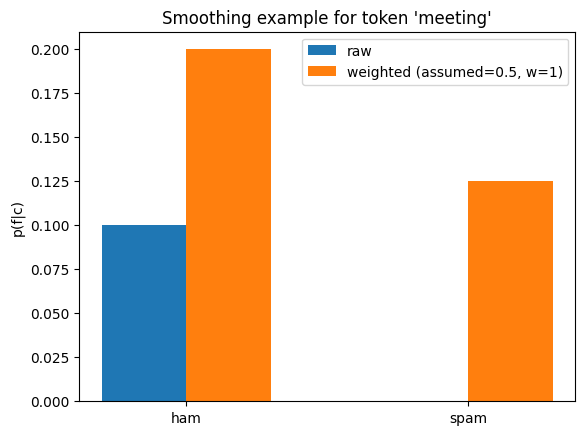

In [10]:
tok = "meeting"
classes = ["ham", "spam"]
raw = [nb_scratch.fprob_raw(tok, c) for c in classes]
smoothed = [nb_scratch.weighted_fprob(tok, c) for c in classes]

plt.figure()
plt.bar(np.arange(len(classes)) - 0.15, raw, width=0.3, label="raw")
plt.bar(np.arange(len(classes)) + 0.15, smoothed, width=0.3, label="weighted (assumed=0.5, w=1)")
plt.xticks(np.arange(len(classes)), classes)
plt.ylabel("p(f|c)")
plt.title(f"Smoothing example for token '{tok}'")
plt.legend()
plt.show()


### 4.4 Evaluate Naïve Bayes (scratch)

In [11]:
def eval_classifier(predict_fn, X, y, positive_label="spam"):
    y_pred = [predict_fn(x) for x in X]
    acc = accuracy_score(y, y_pred)
    pr, rc, f1, _ = precision_recall_fscore_support(
        y, y_pred, pos_label=positive_label, average="binary", zero_division=0
    )
    return {
        "accuracy": float(acc),
        f"precision({positive_label})": float(pr),
        f"recall({positive_label})": float(rc),
        f"f1({positive_label})": float(f1)
    }, y_pred

nb_metrics, nb_pred = eval_classifier(nb_scratch.predict, X_test.tolist(), y_test.tolist(), positive_label="spam")
nb_metrics


{'accuracy': 0.875,
 'precision(spam)': 0.8,
 'recall(spam)': 1.0,
 'f1(spam)': 0.8888888888888888}

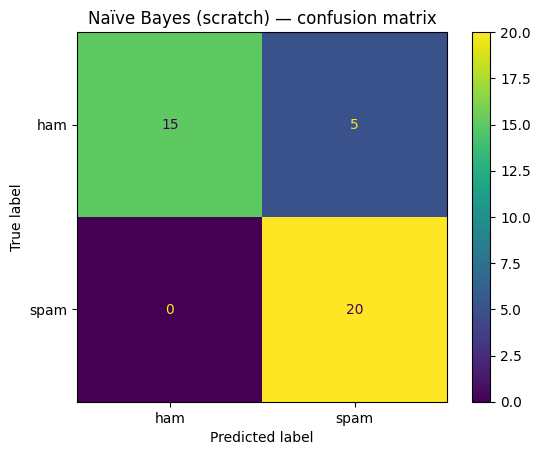

In [12]:
cm = confusion_matrix(y_test, nb_pred, labels=["ham", "spam"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(values_format="d")
plt.title("Naïve Bayes (scratch) — confusion matrix")
plt.show()


### 4.5 Inspect mistakes (useful for teaching)

In [13]:
test_df = pd.DataFrame({"text": X_test, "true": y_test, "pred": nb_pred}).reset_index(drop=True)
mistakes_nb = test_df[test_df["true"] != test_df["pred"]]
mistakes_nb


,text,true,pred
11,Your bank statement is available online.,ham,spam
13,Your flight is confirmed.,ham,spam
16,Can you pick up some milk on your way home?,ham,spam
22,Your appointment is confirmed for 2pm.,ham,spam
39,"I'm running a bit late, be there in 10 minutes.",ham,spam


## 5) Naïve Bayes baselines (scikit-learn)

These are *not* required for the lecture maths, but they help sanity-check the scratch implementation and provide a common reference.

- **BoW (binary) + BernoulliNB**
- **TF–IDF + MultinomialNB**


In [14]:
# BoW (binary presence) + BernoulliNB
sk_bow_nb = BernoulliNB(alpha=1.0)
sk_bow_nb.fit(X_train_bow, y_train)

sk_bow_pred = sk_bow_nb.predict(X_test_bow)
sk_bow_metrics = {
    "accuracy": float(accuracy_score(y_test, sk_bow_pred)),
    **dict(zip(
        ["precision(spam)", "recall(spam)", "f1(spam)"],
        [float(x) for x in precision_recall_fscore_support(y_test, sk_bow_pred, pos_label="spam", average="binary", zero_division=0
        )[:3]]
    ))
}
sk_bow_metrics


{'accuracy': 0.925,
 'precision(spam)': 0.9473684210526315,
 'recall(spam)': 0.9,
 'f1(spam)': 0.9230769230769231}

In [15]:
# TF–IDF + MultinomialNB (very common text baseline)
sk_tfidf_nb = MultinomialNB(alpha=1.0)
sk_tfidf_nb.fit(X_train_tfidf, y_train)

sk_tfidf_pred = sk_tfidf_nb.predict(X_test_tfidf)
sk_tfidf_metrics = {
    "accuracy": float(accuracy_score(y_test, sk_tfidf_pred)),
    **dict(zip(
        ["precision(spam)", "recall(spam)", "f1(spam)"],
        [float(x) for x in precision_recall_fscore_support(y_test, sk_tfidf_pred, pos_label="spam", average="binary", zero_division=0
        )[:3]]
    ))
}
sk_tfidf_metrics


{'accuracy': 0.975,
 'precision(spam)': 0.9523809523809523,
 'recall(spam)': 1.0,
 'f1(spam)': 0.975609756097561}

## 6) Approach B — Fisher’s Method (from scratch)

### 6.1 Per-feature category probability $p(c\mid f)$

Fisher’s method starts by estimating the probability that a **feature implies a category**, using Bayes’ extended form:
$$
p(c\mid f)=\frac{p(f\mid c)\,p(c)}{\sum\limits_{c'\in\mathcal{C}} p(f\mid c')\,p(c')}.
$$

For spam/ham classification, we often assume equal priors:
$$
p(\mathrm{spam})=p(\mathrm{ham})=\tfrac{1}{2}.
$$

Then, for $c\in\{\mathrm{spam},\mathrm{ham}\}$,
$$
p(c\mid f)=\frac{p(f\mid c)}{p(f\mid \mathrm{spam})+p(f\mid \mathrm{ham})}.
$$

### 6.2 Combine multiple $p(c\mid f_i)$ using Fisher’s method

Given $k$ (approximately) independent probabilities $\{p(c\mid f_i)\}_{i=1}^{k}$, Fisher’s method forms the statistic
$$
X^2=-2\sum_{i=1}^{k}\ln\!\bigl(p(c\mid f_i)\bigr),
$$
which follows a chi-square distribution with $2k$ degrees of freedom under the null:
$$
X^2 \sim \chi^2_{2k}.
$$

The combined p-value is
$$
p_C = 1 - F_{\chi^2}\!\left(X^2; 2k\right),
$$
where $F_{\chi^2}(\cdot;\,2k)$ is the CDF of $\chi^2_{2k}$.
(Implementation note: we compute this with the chi-square survival function.)

In [16]:
class FisherScratch:
    '''
    Fisher classifier (as in the slides / 'Programming Collective Intelligence'):
      1) estimate p(c|f) for each feature
      2) combine per-feature probabilities using Fisher's chi-square method
      3) derive a final score:
            I = (1 + p_spam - p_ham) / 2   (tends to 1 for spam, 0 for ham)
    '''
    def __init__(self, assumed: float = 0.5, weight: float = 1.0, prior_equal: bool = True):
        self.assumed = assumed
        self.weight = weight
        self.prior_equal = prior_equal
        self.fc = {}
        self.cc = {}

    @staticmethod
    def features(text: str):
        return set(tokenize(text))

    def incf(self, f, c):
        self.fc.setdefault(f, {})
        self.fc[f][c] = self.fc[f].get(c, 0) + 1

    def incc(self, c):
        self.cc[c] = self.cc.get(c, 0) + 1

    def train(self, texts, labels):
        for text, c in zip(texts, labels):
            feats = self.features(text)
            for f in feats:
                self.incf(f, c)
            self.incc(c)

    def categories(self):
        return list(self.cc.keys())

    def fcount(self, f, c):
        return self.fc.get(f, {}).get(c, 0)

    def catcount(self, c):
        return self.cc.get(c, 0)

    def totalcount(self):
        return sum(self.cc.values())

    def prior(self, c):
        if self.prior_equal:
            return 1.0 / len(self.categories())
        return self.catcount(c) / self.totalcount()

    def fprob(self, f, c):
        if self.catcount(c) == 0:
            return 0.0
        return self.fcount(f, c) / self.catcount(c)

    def cprob_raw(self, f, c):
        denom = 0.0
        for cj in self.categories():
            denom += self.fprob(f, cj) * self.prior(cj)
        if denom == 0:
            return 0.0
        return (self.fprob(f, c) * self.prior(c)) / denom

    def weighted_cprob(self, f, c):
        count = sum(self.fc.get(f, {}).values())
        raw = self.cprob_raw(f, c)
        return (self.weight * self.assumed + count * raw) / (count + self.weight)

    def fisher_prob(self, text, c):
        feats = self.features(text)
        if not feats:
            return 0.0
        ps = [max(self.weighted_cprob(f, c), 1e-12) for f in feats]  # avoid log(0)
        fscore = -2.0 * sum(math.log(p) for p in ps)
        return float(chi2.sf(fscore, df=2 * len(ps)))

    def score_I(self, text):
        p_spam = self.fisher_prob(text, "spam")
        p_ham  = self.fisher_prob(text, "ham")
        return (1.0 + p_spam - p_ham) / 2.0

    def predict(self, text, threshold=0.5):
        return "spam" if self.score_I(text) >= threshold else "ham"

# Train
fish_scratch = FisherScratch(assumed=0.5, weight=1.0, prior_equal=True)
fish_scratch.train(X_train.tolist(), y_train.tolist())

msg = X_test.iloc[0]
print("Message:", msg)
print("p_spam:", fish_scratch.fisher_prob(msg, "spam"))
print("p_ham :", fish_scratch.fisher_prob(msg, "ham"))
print("I (spam score):", fish_scratch.score_I(msg))


Message: Please find attached the minutes from the meeting.
p_spam: 0.2971128450579354
p_ham : 0.8901257567015789
I (spam score): 0.20349354417817828


### 6.3 Evaluate Fisher’s method (scratch)

In [17]:
fish_metrics, fish_pred = eval_classifier(fish_scratch.predict, X_test.tolist(), y_test.tolist())
fish_metrics


{'accuracy': 0.975,
 'precision(spam)': 0.9523809523809523,
 'recall(spam)': 1.0,
 'f1(spam)': 0.975609756097561}

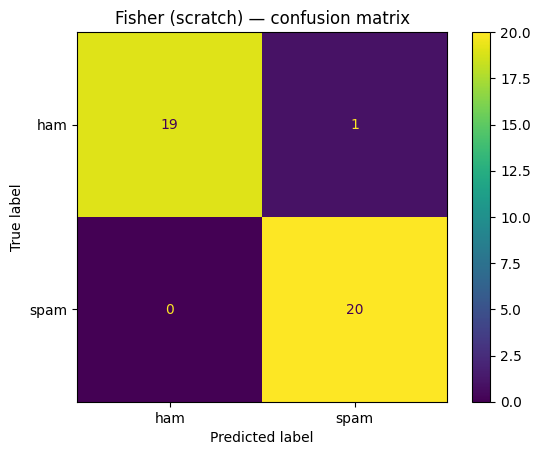

In [18]:
cm = confusion_matrix(y_test, fish_pred, labels=["ham", "spam"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot(values_format="d")
plt.title("Fisher (scratch) — confusion matrix")
plt.show()


### 6.4 Visualise Fisher score distributions

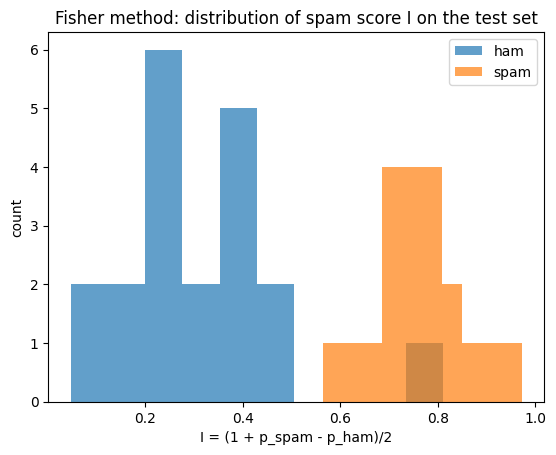

In [19]:
scores = np.array([fish_scratch.score_I(t) for t in X_test.tolist()])
is_spam = (y_test.values == "spam")

plt.figure()
plt.hist(scores[~is_spam], bins=10, alpha=0.7, label="ham")
plt.hist(scores[is_spam],  bins=10, alpha=0.7, label="spam")
plt.xlabel("I = (1 + p_spam - p_ham)/2")
plt.ylabel("count")
plt.title("Fisher method: distribution of spam score I on the test set")
plt.legend()
plt.show()


## 7) Comparison (visual + quantitative)

In [20]:
results = pd.DataFrame({
    "Naïve Bayes (scratch)": nb_metrics,
    "BernoulliNB (BoW)": sk_bow_metrics,
    "MultinomialNB (TF–IDF)": sk_tfidf_metrics,
    "Fisher (scratch)": fish_metrics,
}).T

results


,accuracy,precision(spam),recall(spam),f1(spam)
Naïve Bayes (scratch),0.875,0.800000,1.0,0.888889
BernoulliNB (BoW),0.925,0.947368,0.9,0.923077
MultinomialNB (TF–IDF),0.975,0.952381,1.0,0.975610
Fisher (scratch),0.975,0.952381,1.0,0.975610


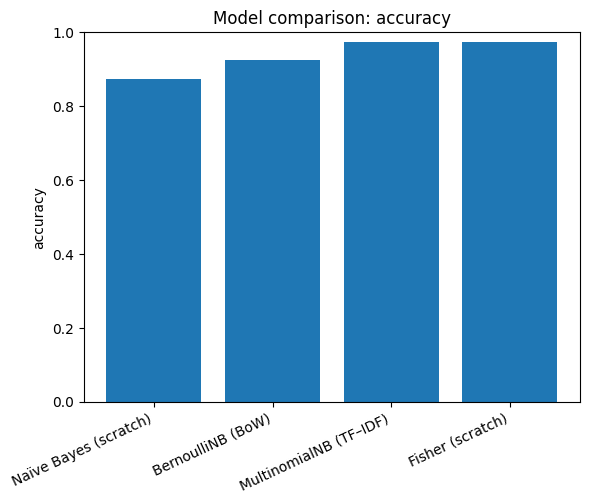

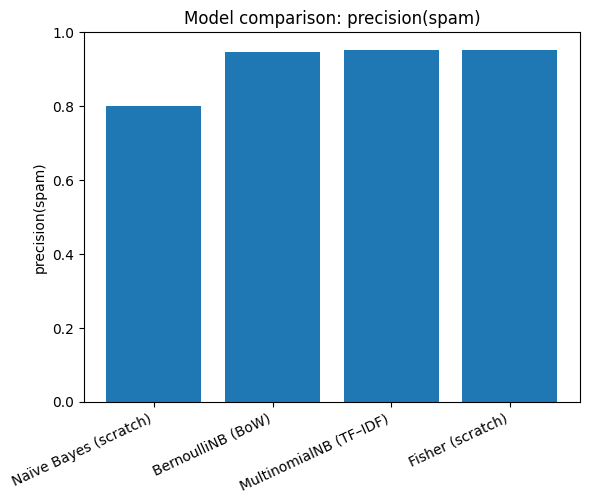

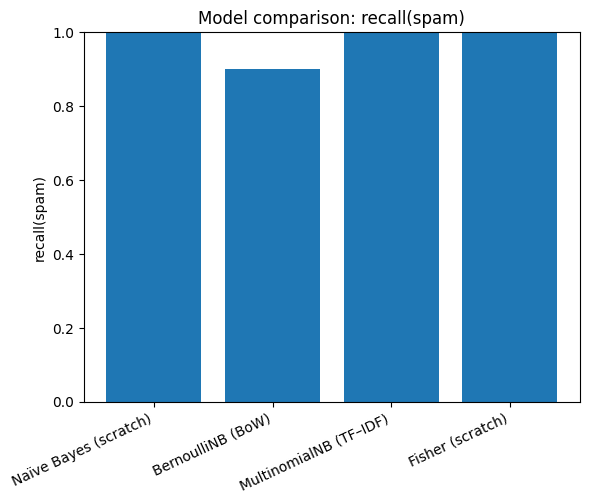

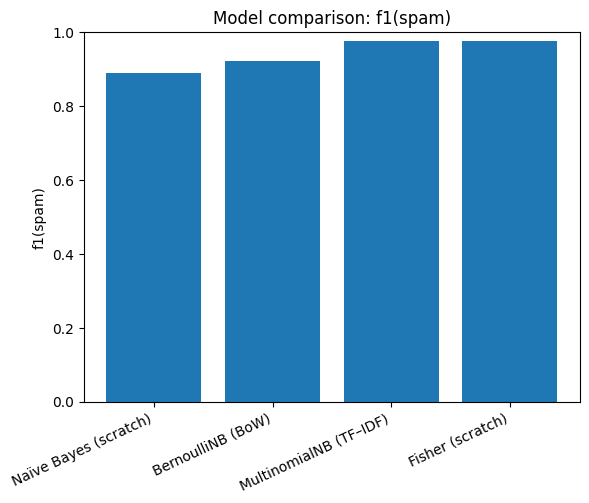

In [21]:
for metric in ["accuracy", "precision(spam)", "recall(spam)", "f1(spam)"]:
    plt.figure()
    plt.bar(results.index, results[metric].values)
    plt.xticks(rotation=25, ha="right")
    plt.ylabel(metric)
    plt.title(f"Model comparison: {metric}")
    plt.ylim(0, 1)
    plt.show()


## 8) Optional feature engineering extension: n-grams (bigrams)

Bag of Words loses word order; **n-grams** partially recover local context (e.g., `"free voucher"`, `"click here"`).


In [22]:
ngram_vec = CountVectorizer(
    tokenizer=tokenize,
    lowercase=False,
    binary=True,
    ngram_range=(1, 2)  # unigrams + bigrams
)

X_train_ng = ngram_vec.fit_transform(X_train)
X_test_ng  = ngram_vec.transform(X_test)

ng_nb = BernoulliNB(alpha=1.0)
ng_nb.fit(X_train_ng, y_train)
ng_pred = ng_nb.predict(X_test_ng)

ng_metrics = {
    "accuracy": float(accuracy_score(y_test, ng_pred)),
    **dict(zip(
        ["precision(spam)", "recall(spam)", "f1(spam)"],
        [float(x) for x in precision_recall_fscore_support(y_test, ng_pred, pos_label="spam", average="binary", zero_division=0
        )[:3]]
    ))
}
ng_metrics


/opt/pyvenv/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


{'accuracy': 0.875,
 'precision(spam)': 0.9411764705882353,
 'recall(spam)': 0.8,
 'f1(spam)': 0.8648648648648649}

## 9) Quick interactive test

Edit `my_message` and re-run the cell to compare models.


In [23]:
def pretty_proba(d: dict):
    return ", ".join([f"{k}={v:.3f}" for k, v in d.items()])

my_message = "Congratulations! You have won a free voucher. Click here now!"
print("Message:", my_message)
print("Naïve Bayes (scratch):", nb_scratch.predict(my_message), pretty_proba(nb_scratch.predict_proba(my_message)))
print("Fisher (scratch):    ", fish_scratch.predict(my_message), f"I={fish_scratch.score_I(my_message):.3f}")

bow_p = bow_vec.transform([my_message])
print("BernoulliNB (BoW):   ", sk_bow_nb.predict(bow_p)[0],
      pretty_proba(dict(zip(sk_bow_nb.classes_, sk_bow_nb.predict_proba(bow_p)[0]))))

tfidf_p = tfidf_vec.transform([my_message])
print("TF–IDF + MultinomialNB:", sk_tfidf_nb.predict(tfidf_p)[0],
      pretty_proba(dict(zip(sk_tfidf_nb.classes_, sk_tfidf_nb.predict_proba(tfidf_p)[0]))))


Message: Congratulations! You have won a free voucher. Click here now!
Naïve Bayes (scratch): spam spam=0.998, ham=0.002
Fisher (scratch):     spam I=0.950
BernoulliNB (BoW):    spam ham=0.000, spam=1.000
TF–IDF + MultinomialNB: spam ham=0.170, spam=0.830


## 10) Summary (mirrors the slide takeaways)

- **Document filtering** is a supervised classification problem (e.g., spam vs ham).

- **Feature engineering** is critical:
  - **Bag of Words** is simple and effective
  - **TF–IDF** reweights words by distinctiveness
  - **$n$-grams** can capture short phrases

- **Naïve Bayes**
  - Estimate $p(f\mid c)$, assume conditional independence, and combine evidence by multiplication  
    (equivalently, sum log-probabilities in practice).
  - Smoothing is essential when data is small.

- **Fisher’s method**
  - Estimate $p(c\mid f)$ per feature and combine evidence via Fisher’s $\chi^2$ method.
  - Produces a natural spam score $I \in [0,1]$.

> **Takeaway:** the choice of features is often as important as the choice of classifier.
